# Task 2 

### Problem Statement

_Implement a circuit that returns $\lvert01\rangle$ and $\lvert10\rangle$ with equal probability._

**Requirements:**
- The circuit should consist only of CNOTs, RXs and RYs. 
- Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
- You should find the right set of parameters using gradient descent (you might use more advanced optimization methods if you like). 
- Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

**Bonus question:
How to make sure you produce state $\lvert01\rangle$ + $\lvert10\rangle$ and not $\lvert01\rangle$ - $\lvert10\rangle$?**

---

I've decided to use **Qiskit 0.20.0** for this task - it's the one I'm most comfortable with. Version details follow...

In [23]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.15.1',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.20.0'}

## Creating a reference circuit

For starters, I decided to make a reference circuit that creates the state $\lvert\psi\rangle = \lvert01\rangle + \lvert10\rangle$ (upto a global phase) using only RX, RY, and CX gates. The intention behind was this was to have something against which I could compare the circuits that my program _learnt_. This was not strictly necessary - I could have skipped the circuit altogether and just initialized the `Statevector()` object, but this way I don't have to worry about normalizing the state manually. It also lets me experiment with different reference circuits easily and run the circuits using the `QasmSimulator()`.

In [28]:
# imports and general configuration
import random
import numpy as np

from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram as plot_h, plot_state_qsphere as plot_q
from qiskit.quantum_info import Statevector
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

config = {
    'output': 'mpl',
    'sv_sim': Aer.get_backend('statevector_simulator'),
    'qasm_sim': Aer.get_backend('qasm_simulator'),
    'shots': 1024,
    'qsphere_fig_size': (6.5, 6.5)
}

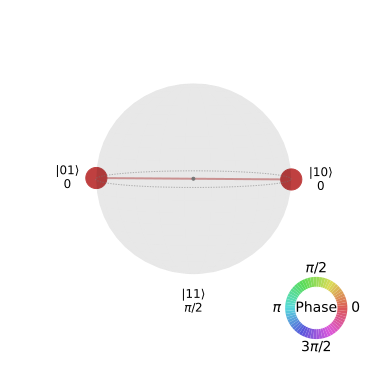

In [49]:
t2_ref_ckt = QuantumCircuit(2)

# X gate on qubit 1
t2_ref_ckt.rx(np.pi, 1)
# Hadamard on qubit 0
t2_ref_ckt.ry(np.pi/2, 0) 
t2_ref_ckt.rx(np.pi, 0)
# CNOT with qubit 0 as control and qubit 1 as target
t2_ref_ckt.cx(0,1)

# evolving the Statevector() using the QuantumCircuit() to reach the final state
# this way there's no need for a simulator 
ref_sv = Statevector.from_label('00').evolve(t2_ref_ckt)

# plot the state on the q-sphere for visualization
plot_q(ref_sv, figsize=config['qsphere_fig_size'], show_state_phases=True)

## Approach 1

This first approach is straightforward. The order of the gates is fixed and I'm attempting to learn the parameters of the RX and RY gates using Gradient Descent...
Since the CX gate can be pushed to the end of the circuit, we only need to worry about generating the state that, on application of a CX gate, would give us $\lvert\psi\rangle$, which turns out to be $\lvert\psi^\prime\rangle = \lvert01\rangle + \lvert11\rangle = \lvert+\rangle\otimes\lvert1\rangle$.

This state is completely separable, which means I can treat each qubit individually and optimize one at a time...

h = 90y 180x  
x = rxpi

In [166]:
# Initialize circuit parameters
q0_thetas = 2 * np.pi * np.random.rand(2)
q1_thetas = 2 * np.pi * np.random.rand(2)

q0_thetas, q1_thetas

(array([1.6037879 , 5.02057008]), array([1.06754129, 2.4235893 ]))

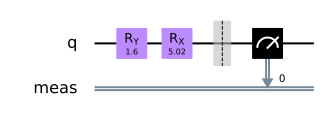

In [167]:
a1_ckt1 = QuantumCircuit(1)

a1_ckt1.ry(q0_thetas[0], 0)
a1_ckt1.rx(q0_thetas[1], 0)
a1_ckt1.measure_all()
# t2_ckt1.cx(0, 1)

a1_ckt1.draw(config['output'])

In [168]:
initial_state_1 = Statevector.from_label('0')
#final_state_1 = initial_state_1.evolve(a1_ckt1)

#rounded_final_state_1 = Statevector(np.array([round(y, 3) for y in final_state_1.data]))
#rounded_final_state_1.probabilities_dict()

In [171]:
alpha = 0.01
for _ in range(1000):
    res = execute(a1_ckt1, backend=config['qasm_sim'], shots=1000).result()
    counts = res.get_counts()
    print(counts)
    #final_state_probs = initial_state.evolve(a1_ckt1).probabilities_dict()
    p0 = counts['0']/1000
    p1 = counts['1']/1000
    cost = (p0-0.5)**2 + (p1-0.5)**2
    print("cost: ", cost)
    partial_1 = np.sin(q0_thetas[0])*np.cos(q0_thetas[1])*(p1-p0)
    partial_2 = np.sin(q0_thetas[1])*np.cos(q0_thetas[0])*(p1-p0)
    #print("par1, par2", partial_1, partial_2)
    q0_thetas = [q0_thetas[0]-alpha*partial_1, q0_thetas[1]-alpha*partial_2]
    a1_ckt1 = QuantumCircuit(1)
    a1_ckt1.ry(q0_thetas[0], 0)
    a1_ckt1.rx(q0_thetas[1], 0)
    a1_ckt1.measure_all()
    
print(q0_thetas)

{'0': 489, '1': 511}
cost:  0.00024200000000000043
{'0': 490, '1': 510}
cost:  0.00020000000000000036
{'0': 498, '1': 502}
cost:  8.000000000000015e-06
{'0': 501, '1': 499}
cost:  2.0000000000000037e-06
{'0': 504, '1': 496}
cost:  3.200000000000006e-05
{'0': 524, '1': 476}
cost:  0.001152000000000002
{'0': 501, '1': 499}
cost:  2.0000000000000037e-06
{'0': 488, '1': 512}
cost:  0.0002880000000000005
{'0': 500, '1': 500}
cost:  0.0
{'0': 515, '1': 485}
cost:  0.0004500000000000008
{'0': 470, '1': 530}
cost:  0.0018000000000000032
{'0': 501, '1': 499}
cost:  2.0000000000000037e-06
{'0': 492, '1': 508}
cost:  0.00012800000000000024
{'0': 488, '1': 512}
cost:  0.0002880000000000005
{'0': 507, '1': 493}
cost:  9.800000000000017e-05
{'0': 480, '1': 520}
cost:  0.0008000000000000014
{'0': 484, '1': 516}
cost:  0.000512000000000001
{'0': 485, '1': 515}
cost:  0.0004500000000000008
{'0': 479, '1': 521}
cost:  0.0008820000000000016
{'0': 508, '1': 492}
cost:  0.00012800000000000024
{'0': 507, '1

{'0': 491, '1': 509}
cost:  0.00016200000000000028
{'0': 505, '1': 495}
cost:  5.000000000000009e-05
{'0': 515, '1': 485}
cost:  0.0004500000000000008
{'0': 448, '1': 552}
cost:  0.005408000000000004
{'0': 493, '1': 507}
cost:  9.800000000000017e-05
{'0': 514, '1': 486}
cost:  0.0003920000000000007
{'0': 466, '1': 534}
cost:  0.0023120000000000003
{'0': 511, '1': 489}
cost:  0.00024200000000000043
{'0': 526, '1': 474}
cost:  0.0013520000000000025
{'0': 471, '1': 529}
cost:  0.001682000000000003
{'0': 516, '1': 484}
cost:  0.000512000000000001
{'0': 533, '1': 467}
cost:  0.0021780000000000002
{'0': 484, '1': 516}
cost:  0.000512000000000001
{'0': 505, '1': 495}
cost:  5.000000000000009e-05
{'0': 502, '1': 498}
cost:  8.000000000000015e-06
{'0': 492, '1': 508}
cost:  0.00012800000000000024
{'0': 490, '1': 510}
cost:  0.00020000000000000036
{'0': 492, '1': 508}
cost:  0.00012800000000000024
{'0': 534, '1': 466}
cost:  0.0023120000000000003
{'0': 497, '1': 503}
cost:  1.800000000000003e-05

{'0': 499, '1': 501}
cost:  2.0000000000000037e-06
{'0': 474, '1': 526}
cost:  0.0013520000000000025
{'0': 532, '1': 468}
cost:  0.0020480000000000003
{'0': 528, '1': 472}
cost:  0.0015680000000000028
{'0': 503, '1': 497}
cost:  1.800000000000003e-05
{'0': 479, '1': 521}
cost:  0.0008820000000000016
{'0': 485, '1': 515}
cost:  0.0004500000000000008
{'0': 481, '1': 519}
cost:  0.0007220000000000013
{'0': 515, '1': 485}
cost:  0.0004500000000000008
{'0': 536, '1': 464}
cost:  0.0025920000000000006
{'0': 448, '1': 552}
cost:  0.005408000000000004
{'0': 464, '1': 536}
cost:  0.0025920000000000006
{'0': 497, '1': 503}
cost:  1.800000000000003e-05
{'0': 501, '1': 499}
cost:  2.0000000000000037e-06
{'0': 478, '1': 522}
cost:  0.0009680000000000017
{'0': 480, '1': 520}
cost:  0.0008000000000000014
{'0': 518, '1': 482}
cost:  0.0006480000000000011
{'0': 489, '1': 511}
cost:  0.00024200000000000043
{'0': 504, '1': 496}
cost:  3.200000000000006e-05
{'0': 495, '1': 505}
cost:  5.000000000000009e-0

{'0': 491, '1': 509}
cost:  0.00016200000000000028
{'0': 466, '1': 534}
cost:  0.0023120000000000003
{'0': 538, '1': 462}
cost:  0.002888000000000001
{'0': 514, '1': 486}
cost:  0.0003920000000000007
{'0': 502, '1': 498}
cost:  8.000000000000015e-06
{'0': 509, '1': 491}
cost:  0.00016200000000000028
{'0': 486, '1': 514}
cost:  0.0003920000000000007
{'0': 499, '1': 501}
cost:  2.0000000000000037e-06
{'0': 505, '1': 495}
cost:  5.000000000000009e-05
{'0': 489, '1': 511}
cost:  0.00024200000000000043
{'0': 516, '1': 484}
cost:  0.000512000000000001
{'0': 524, '1': 476}
cost:  0.001152000000000002
{'0': 522, '1': 478}
cost:  0.0009680000000000017
{'0': 522, '1': 478}
cost:  0.0009680000000000017
{'0': 491, '1': 509}
cost:  0.00016200000000000028
{'0': 488, '1': 512}
cost:  0.0002880000000000005
{'0': 487, '1': 513}
cost:  0.0003380000000000006
{'0': 504, '1': 496}
cost:  3.200000000000006e-05
{'0': 495, '1': 505}
cost:  5.000000000000009e-05
{'0': 520, '1': 480}
cost:  0.000800000000000001

{'0': 484, '1': 516}
cost:  0.000512000000000001
{'0': 519, '1': 481}
cost:  0.0007220000000000013
{'0': 465, '1': 535}
cost:  0.0024500000000000004
{'0': 487, '1': 513}
cost:  0.0003380000000000006
{'0': 482, '1': 518}
cost:  0.0006480000000000011
{'0': 501, '1': 499}
cost:  2.0000000000000037e-06
{'0': 492, '1': 508}
cost:  0.00012800000000000024
{'0': 473, '1': 527}
cost:  0.0014580000000000027
{'0': 494, '1': 506}
cost:  7.200000000000012e-05
{'0': 486, '1': 514}
cost:  0.0003920000000000007
{'0': 523, '1': 477}
cost:  0.0010580000000000019
{'0': 528, '1': 472}
cost:  0.0015680000000000028
{'0': 509, '1': 491}
cost:  0.00016200000000000028
{'0': 499, '1': 501}
cost:  2.0000000000000037e-06
{'0': 496, '1': 504}
cost:  3.200000000000006e-05
{'0': 481, '1': 519}
cost:  0.0007220000000000013
{'0': 475, '1': 525}
cost:  0.0012500000000000022
{'0': 506, '1': 494}
cost:  7.200000000000012e-05
{'0': 508, '1': 492}
cost:  0.00012800000000000024
{'0': 495, '1': 505}
cost:  5.000000000000009e

{'0': 496, '1': 504}
cost:  3.200000000000006e-05
{'0': 519, '1': 481}
cost:  0.0007220000000000013
{'0': 500, '1': 500}
cost:  0.0
{'0': 481, '1': 519}
cost:  0.0007220000000000013
{'0': 518, '1': 482}
cost:  0.0006480000000000011
{'0': 514, '1': 486}
cost:  0.0003920000000000007
{'0': 493, '1': 507}
cost:  9.800000000000017e-05
{'0': 508, '1': 492}
cost:  0.00012800000000000024
{'0': 495, '1': 505}
cost:  5.000000000000009e-05
{'0': 514, '1': 486}
cost:  0.0003920000000000007
{'0': 501, '1': 499}
cost:  2.0000000000000037e-06
{'0': 487, '1': 513}
cost:  0.0003380000000000006
{'0': 470, '1': 530}
cost:  0.0018000000000000032
{'0': 494, '1': 506}
cost:  7.200000000000012e-05
{'0': 499, '1': 501}
cost:  2.0000000000000037e-06
{'0': 520, '1': 480}
cost:  0.0008000000000000014
{'0': 482, '1': 518}
cost:  0.0006480000000000011
{'0': 495, '1': 505}
cost:  5.000000000000009e-05
{'0': 495, '1': 505}
cost:  5.000000000000009e-05
{'0': 522, '1': 478}
cost:  0.0009680000000000017
{'0': 501, '1':

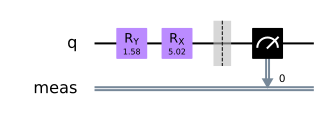

In [170]:
a1_ckt1.draw(config['output'])

Now for the second qubit...

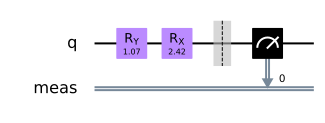

In [172]:
a1_ckt2 = QuantumCircuit(1)

a1_ckt2.ry(q1_thetas[0], 0)
a1_ckt2.rx(q1_thetas[1], 0)
a1_ckt2.measure_all()
# t2_ckt1.cx(0, 1)

a1_ckt2.draw(config['output'])

In [173]:
alpha = 0.01
for _ in range(1000):
    res = execute(a1_ckt2, backend=config['qasm_sim'], shots=1000).result()
    counts = res.get_counts()
    print(counts)
    #final_state_probs = initial_state.evolve(a1_ckt1).probabilities_dict()
    p0 = counts['0']/1000
    p1 = counts['1']/1000
    cost = (p0)**2 + (p1-1)**2
    print("cost: ", cost)
    partial_1 = np.sin(q1_thetas[0])*np.cos(q1_thetas[1])*(p1-p0-1)
    partial_2 = np.sin(q1_thetas[1])*np.cos(q1_thetas[0])*(p1-p0-1)
    #print("par1, par2", partial_1, partial_2)
    q1_thetas = [q1_thetas[0]-alpha*partial_1, q1_thetas[1]-alpha*partial_2]
    a1_ckt2 = QuantumCircuit(1)
    a1_ckt2.ry(q1_thetas[0], 0)
    a1_ckt2.rx(q1_thetas[1], 0)
    a1_ckt2.measure_all()
    
print(q1_thetas)

{'0': 320, '1': 680}
cost:  0.20479999999999998
{'0': 300, '1': 700}
cost:  0.18000000000000002
{'0': 300, '1': 700}
cost:  0.18000000000000002
{'0': 338, '1': 662}
cost:  0.228488
{'0': 303, '1': 697}
cost:  0.18361800000000003
{'0': 299, '1': 701}
cost:  0.17880200000000002
{'0': 294, '1': 706}
cost:  0.17287200000000003
{'0': 324, '1': 676}
cost:  0.20995199999999997
{'0': 295, '1': 705}
cost:  0.17405
{'0': 267, '1': 733}
cost:  0.142578
{'0': 304, '1': 696}
cost:  0.18483200000000002
{'0': 311, '1': 689}
cost:  0.19344200000000003
{'0': 306, '1': 694}
cost:  0.18727200000000002
{'0': 307, '1': 693}
cost:  0.18849800000000003
{'0': 286, '1': 714}
cost:  0.16359200000000002
{'0': 284, '1': 716}
cost:  0.161312
{'0': 291, '1': 709}
cost:  0.169362
{'0': 320, '1': 680}
cost:  0.20479999999999998
{'0': 313, '1': 687}
cost:  0.19593799999999995
{'0': 272, '1': 728}
cost:  0.14796800000000002
{'0': 302, '1': 698}
cost:  0.18240800000000001
{'0': 268, '1': 732}
cost:  0.14364800000000003


{'0': 129, '1': 871}
cost:  0.033282
{'0': 139, '1': 861}
cost:  0.03864200000000001
{'0': 121, '1': 879}
cost:  0.029282
{'0': 122, '1': 878}
cost:  0.029768
{'0': 117, '1': 883}
cost:  0.027378
{'0': 116, '1': 884}
cost:  0.026912
{'0': 122, '1': 878}
cost:  0.029768
{'0': 135, '1': 865}
cost:  0.03645
{'0': 134, '1': 866}
cost:  0.035912000000000006
{'0': 131, '1': 869}
cost:  0.034322000000000005
{'0': 123, '1': 877}
cost:  0.030258
{'0': 133, '1': 867}
cost:  0.03537800000000001
{'0': 130, '1': 870}
cost:  0.033800000000000004
{'0': 131, '1': 869}
cost:  0.034322000000000005
{'0': 126, '1': 874}
cost:  0.031752
{'0': 116, '1': 884}
cost:  0.026912
{'0': 103, '1': 897}
cost:  0.021217999999999994
{'0': 122, '1': 878}
cost:  0.029768
{'0': 108, '1': 892}
cost:  0.023327999999999995
{'0': 117, '1': 883}
cost:  0.027378
{'0': 116, '1': 884}
cost:  0.026912
{'0': 126, '1': 874}
cost:  0.031752
{'0': 128, '1': 872}
cost:  0.032768
{'0': 121, '1': 879}
cost:  0.029282
{'0': 129, '1': 871

{'0': 81, '1': 919}
cost:  0.013121999999999995
{'0': 91, '1': 909}
cost:  0.016561999999999993
{'0': 90, '1': 910}
cost:  0.016199999999999992
{'0': 79, '1': 921}
cost:  0.012481999999999993
{'0': 64, '1': 936}
cost:  0.008191999999999993
{'0': 73, '1': 927}
cost:  0.010657999999999994
{'0': 70, '1': 930}
cost:  0.009799999999999993
{'0': 73, '1': 927}
cost:  0.010657999999999994
{'0': 76, '1': 924}
cost:  0.011551999999999993
{'0': 72, '1': 928}
cost:  0.010367999999999992
{'0': 61, '1': 939}
cost:  0.007442000000000006
{'0': 92, '1': 908}
cost:  0.01692799999999999
{'0': 79, '1': 921}
cost:  0.012481999999999993
{'0': 67, '1': 933}
cost:  0.008977999999999993
{'0': 68, '1': 932}
cost:  0.009247999999999992
{'0': 71, '1': 929}
cost:  0.010081999999999994
{'0': 83, '1': 917}
cost:  0.013777999999999995
{'0': 73, '1': 927}
cost:  0.010657999999999994
{'0': 56, '1': 944}
cost:  0.006272000000000006
{'0': 74, '1': 926}
cost:  0.010951999999999993
{'0': 69, '1': 931}
cost:  0.009521999999

{'0': 43, '1': 957}
cost:  0.003698000000000003
{'0': 62, '1': 938}
cost:  0.0076880000000000065
{'0': 52, '1': 948}
cost:  0.005408000000000005
{'0': 45, '1': 955}
cost:  0.004050000000000003
{'0': 45, '1': 955}
cost:  0.004050000000000003
{'0': 45, '1': 955}
cost:  0.004050000000000003
{'0': 44, '1': 956}
cost:  0.003872000000000003
{'0': 50, '1': 950}
cost:  0.0050000000000000044
{'0': 39, '1': 961}
cost:  0.0030420000000000026
{'0': 33, '1': 967}
cost:  0.002178000000000002
{'0': 44, '1': 956}
cost:  0.003872000000000003
{'0': 40, '1': 960}
cost:  0.003200000000000003
{'0': 43, '1': 957}
cost:  0.003698000000000003
{'0': 42, '1': 958}
cost:  0.0035280000000000034
{'0': 51, '1': 949}
cost:  0.005202000000000004
{'0': 58, '1': 942}
cost:  0.0067280000000000065
{'0': 51, '1': 949}
cost:  0.005202000000000004
{'0': 45, '1': 955}
cost:  0.004050000000000003
{'0': 38, '1': 962}
cost:  0.0028880000000000025
{'0': 54, '1': 946}
cost:  0.005832000000000006
{'0': 48, '1': 952}
cost:  0.00460

{'0': 36, '1': 964}
cost:  0.0025920000000000023
{'0': 39, '1': 961}
cost:  0.0030420000000000026
{'0': 42, '1': 958}
cost:  0.0035280000000000034
{'0': 44, '1': 956}
cost:  0.003872000000000003
{'0': 37, '1': 963}
cost:  0.002738000000000002
{'0': 32, '1': 968}
cost:  0.002048000000000002
{'0': 41, '1': 959}
cost:  0.003362000000000003
{'0': 34, '1': 966}
cost:  0.0023120000000000024
{'0': 41, '1': 959}
cost:  0.003362000000000003
{'0': 43, '1': 957}
cost:  0.003698000000000003
{'0': 36, '1': 964}
cost:  0.0025920000000000023
{'0': 26, '1': 974}
cost:  0.0013520000000000012
{'0': 37, '1': 963}
cost:  0.002738000000000002
{'0': 31, '1': 969}
cost:  0.0019220000000000016
{'0': 33, '1': 967}
cost:  0.002178000000000002
{'0': 31, '1': 969}
cost:  0.0019220000000000016
{'0': 39, '1': 961}
cost:  0.0030420000000000026
{'0': 46, '1': 954}
cost:  0.004232000000000003
{'0': 44, '1': 956}
cost:  0.003872000000000003
{'0': 32, '1': 968}
cost:  0.002048000000000002
{'0': 44, '1': 956}
cost:  0.00

{'0': 17, '1': 983}
cost:  0.0005780000000000006
{'0': 41, '1': 959}
cost:  0.003362000000000003
{'0': 28, '1': 972}
cost:  0.0015680000000000015
{'0': 26, '1': 974}
cost:  0.0013520000000000012
{'0': 25, '1': 975}
cost:  0.0012500000000000011
{'0': 28, '1': 972}
cost:  0.0015680000000000015
{'0': 39, '1': 961}
cost:  0.0030420000000000026
{'0': 34, '1': 966}
cost:  0.0023120000000000024
{'0': 29, '1': 971}
cost:  0.0016820000000000016
{'0': 27, '1': 973}
cost:  0.0014580000000000014
{'0': 23, '1': 977}
cost:  0.0010580000000000008
{'0': 24, '1': 976}
cost:  0.0011520000000000011
{'0': 27, '1': 973}
cost:  0.0014580000000000014
{'0': 29, '1': 971}
cost:  0.0016820000000000016
{'0': 31, '1': 969}
cost:  0.0019220000000000016
{'0': 30, '1': 970}
cost:  0.0018000000000000017
{'0': 26, '1': 974}
cost:  0.0013520000000000012
{'0': 21, '1': 979}
cost:  0.0008820000000000008
{'0': 29, '1': 971}
cost:  0.0016820000000000016
{'0': 32, '1': 968}
cost:  0.002048000000000002
{'0': 30, '1': 970}
co

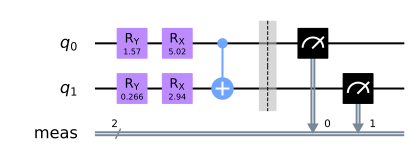

In [197]:
final_ckt = QuantumCircuit(2)
final_ckt.ry(q0_thetas[0], 0)
final_ckt.rx(q0_thetas[1], 0)
final_ckt.ry(q1_thetas[0], 1)
final_ckt.rx(q1_thetas[1], 1)
final_ckt.cx(0,1)
final_ckt.measure_all()
final_ckt.draw('mpl')

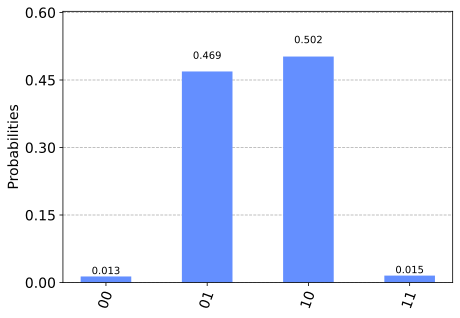

In [198]:
from qiskit.visualization import plot_histogram as plot_h

res = execute(final_ckt, backend=config['qasm_sim'], shots=4096).result()
plot_h(res.get_counts())

In [205]:
res2 = execute(final_ckt.remove_final_measurements(inplace=False), backend=config['sv_sim']).result()
sv = res2.get_statevector()
Statevector(sv).probabilities_dict()

#final_ckt.draw('mpl')

{'00': 0.013536206084825964,
 '01': 0.48701461107459443,
 '10': 0.4858814067320729,
 '11': 0.013567776108506761}

In [ ]:
%autosave 30
import qiskit
qiskit.__qiskit_version__
